In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate, RandomizedSearchCV, StratifiedKFold, KFold
from sklearn.metrics import (
    accuracy_score, balanced_accuracy_score, classification_report, roc_auc_score, 
    roc_curve, confusion_matrix, make_scorer, precision_score, recall_score, 
    cohen_kappa_score, log_loss
)
from sklearn.metrics import precision_recall_curve, average_precision_score

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
import lightgbm as lgb
from lightgbm import LGBMClassifier
import scikitplot as skplt
import shap

from plotly.offline import init_notebook_mode
import plotly.express as px
import plotly.io as pio
import plotly.graph_objs as go

from rr_project.config.const import SEED

# Initialize plotly notebook mode
init_notebook_mode(connected=True)
sns.set_style("whitegrid")


## Challenger model - lightGBM

In [20]:
from rr_project.data_wrangling import preprocess_data

df = pd.read_csv("data/credit_card_2018.csv")
preprocessed_df = preprocess_data(df)

C:\Users\adamj\AppData\Local\Temp\ipykernel_15204\395638990.py:3: DtypeWarning:

Columns (129,130,131,134,135,136,139,145,146,147) have mixed types. Specify dtype option on import or set low_memory=False.



Source data shape: (127702, 153). 
Source data target distribution:
0    124626
1      3076
Name: target, dtype: int64
Bads for month 1: 420. Goods for month 1: 1680.
Bads for month 2: 323. Goods for month 2: 1292.
Bads for month 3: 390. Goods for month 3: 1560.
Bads for month 4: 394. Goods for month 4: 1576.
Bads for month 5: 361. Goods for month 5: 1444.
Bads for month 6: 310. Goods for month 6: 1240.
Bads for month 7: 271. Goods for month 7: 1084.
Bads for month 8: 213. Goods for month 8: 852.
Bads for month 9: 136. Goods for month 9: 544.
Bads for month 10: 133. Goods for month 10: 532.
Bads for month 11: 80. Goods for month 11: 320.
Bads for month 12: 45. Goods for month 12: 180.
Undersampled data shape: (15380, 153). 
Undersampled data target distribution:
0    12304
1     3076
Name: target, dtype: int64


In [21]:
# Drop the id column
df = df.drop(['id', 'member_id'], axis=1)

In [22]:
# Check for missing values
missing_values = df.isna().mean()*100
missing_values

loan_amnt                 0.000000
funded_amnt               0.000000
funded_amnt_inv           0.000000
term                      0.000000
int_rate                  0.000000
                           ...    
settlement_amount        99.937354
settlement_percentage    99.937354
settlement_term          99.937354
month                     0.000000
target                    0.000000
Length: 151, dtype: float64

In [23]:
# Check for duplicated rows
df.duplicated().sum()

0

In [24]:
# Descriptive statistics
df.describe()

,loan_amnt,funded_amnt,funded_amnt_inv,int_rate,installment,annual_inc,desc,dti,delinq_2yrs,fico_range_low,...,hardship_length,hardship_dpd,orig_projected_additional_accrued_interest,hardship_payoff_balance_amount,hardship_last_payment_amount,settlement_amount,settlement_percentage,settlement_term,month,target
count,127702.000000,127702.000000,127702.000000,127702.000000,127702.000000,1.277020e+05,0.0,127470.000000,127702.000000,127702.000000,...,64.0,64.000000,58.000000,64.000000,64.000000,80.000000,80.000000,80.000000,127702.000000,127702.000000
mean,15649.050328,15649.050328,15645.538532,11.374782,454.021908,7.968977e+04,NaN,19.682084,0.190796,703.300262,...,3.0,10.828125,545.152241,16066.785000,167.184687,7012.535000,54.253625,18.637500,6.879610,0.024087
std,9609.575103,9609.575103,9609.474252,4.584419,271.408547,8.521683e+04,NaN,19.420025,0.653752,33.258738,...,0.0,9.291667,378.531340,9144.241979,141.835690,4276.407154,9.282930,5.292086,3.307129,0.153321
min,1000.000000,1000.000000,750.000000,5.310000,30.120000,0.000000e+00,NaN,0.000000,0.000000,660.000000,...,3.0,0.000000,72.180000,2441.010000,0.100000,989.000000,40.000000,3.000000,1.000000,0.000000
25%,9000.000000,9000.000000,9000.000000,7.560000,260.250000,4.600000e+04,NaN,11.842500,0.000000,675.000000,...,3.0,1.000000,257.182500,8797.817500,41.107500,3603.477500,45.000000,18.000000,4.000000,0.000000
50%,13000.000000,13000.000000,13000.000000,10.470000,372.400000,6.500000e+04,NaN,17.890000,0.000000,695.000000,...,3.0,9.500000,455.520000,13960.130000,153.205000,5839.000000,55.000000,18.000000,7.000000,0.000000
75%,20000.000000,20000.000000,20000.000000,14.070000,600.730000,9.500000e+04,NaN,24.940000,0.000000,720.000000,...,3.0,18.000000,738.915000,21341.022500,282.827500,9804.750000,65.000000,24.000000,10.000000,0.000000
max,40000.000000,40000.000000,40000.000000,30.990000,1597.600000,9.000000e+06,NaN,999.000000,23.000000,845.000000,...,3.0,29.000000,2154.750000,37686.950000,523.480000,21142.000000,65.120000,24.000000,12.000000,1.000000


In [25]:
# Check all the columns
df.columns.tolist()

['loan_amnt',
 'funded_amnt',
 'funded_amnt_inv',
 'term',
 'int_rate',
 'installment',
 'grade',
 'sub_grade',
 'emp_title',
 'emp_length',
 'home_ownership',
 'annual_inc',
 'verification_status',
 'issue_d',
 'loan_status',
 'pymnt_plan',
 'url',
 'desc',
 'purpose',
 'title',
 'zip_code',
 'addr_state',
 'dti',
 'delinq_2yrs',
 'earliest_cr_line',
 'fico_range_low',
 'fico_range_high',
 'inq_last_6mths',
 'mths_since_last_delinq',
 'mths_since_last_record',
 'open_acc',
 'pub_rec',
 'revol_bal',
 'revol_util',
 'total_acc',
 'initial_list_status',
 'out_prncp',
 'out_prncp_inv',
 'total_pymnt',
 'total_pymnt_inv',
 'total_rec_prncp',
 'total_rec_int',
 'total_rec_late_fee',
 'recoveries',
 'collection_recovery_fee',
 'last_pymnt_d',
 'last_pymnt_amnt',
 'next_pymnt_d',
 'last_credit_pull_d',
 'last_fico_range_high',
 'last_fico_range_low',
 'collections_12_mths_ex_med',
 'mths_since_last_major_derog',
 'policy_code',
 'application_type',
 'annual_inc_joint',
 'dti_joint',
 'verific

In [26]:
# Check again the data types
df.dtypes

loan_amnt                float64
funded_amnt              float64
funded_amnt_inv          float64
term                      object
int_rate                 float64
                          ...   
settlement_amount        float64
settlement_percentage    float64
settlement_term          float64
month                      int64
target                     int64
Length: 151, dtype: object

In [27]:
continuous_variables_vis = [
    'loan_amnt',
    'funded_amnt',
    'int_rate',
    'installment',
    'open_acc',
    'total_pymnt',
    'total_rec_int',
]

categorical_variables_vis = [
    'grade',
    'term',
    'application_type',
    'inq_last_6mths',
    'home_ownership',
    'target',
]

In [28]:
df.drop(['emp_title', 'url', 'zip_code', 'earliest_cr_line', 'sec_app_earliest_cr_line', 'desc', 'loan_status'], axis=1, inplace=True)

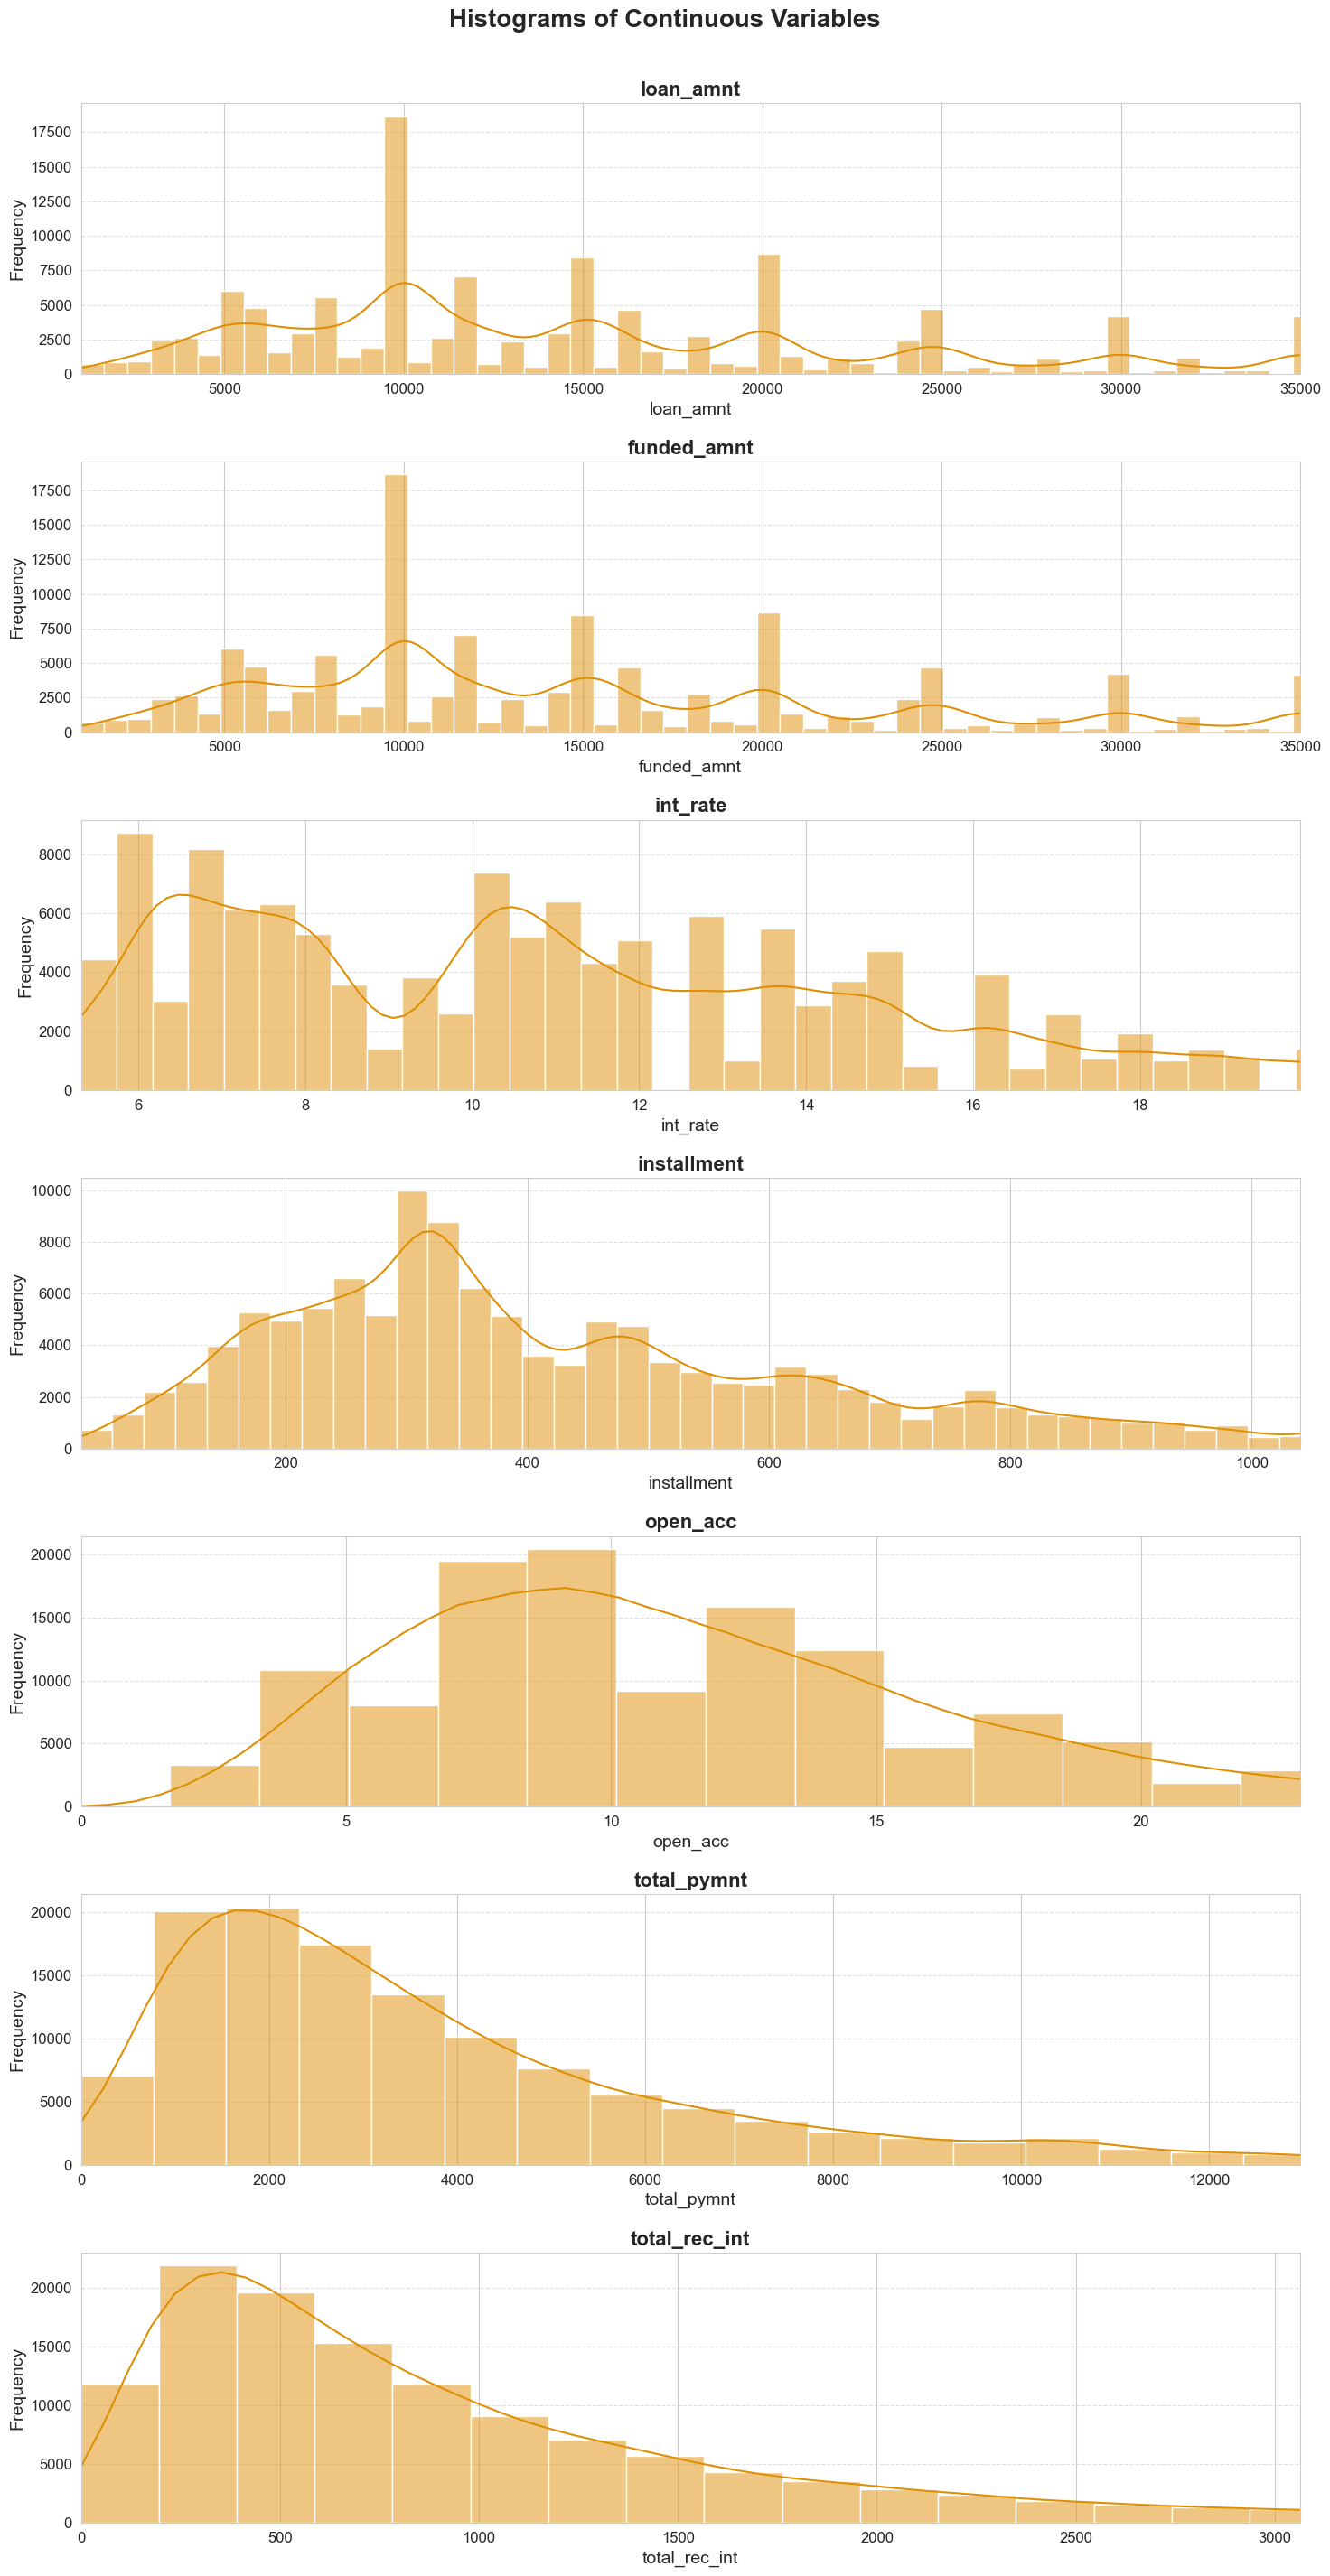

In [29]:
# Plot histograms of continuous variables
def plot_histograms(
    data: pd.DataFrame,
    columns: list,
    bins: int = 100,
    min_quantile: float = 0.0,
    max_quantile: float = 0.99,
) -> None:
    sns.set_palette("colorblind")

    fig, axes = plt.subplots(len(columns), 1)
    fig.set_size_inches(15, 4 * len(columns))

    for ax, col in zip(axes, columns):
        sns.histplot(data[col], bins=bins, kde=True, ax=ax, color=sns.color_palette()[1])

        ax.set_xlabel(col, fontsize=14)
        ax.set_ylabel('Frequency', fontsize=14) 
        ax.set_title(col, fontsize=16, fontweight='bold')

        ax.grid(axis='y', linestyle='--', alpha=0.6)

        ax.tick_params(axis='both', which='major', labelsize=12)
        ax.tick_params(axis='both', which='minor', labelsize=10)

        ax.set_xlim(data[col].quantile(q=min_quantile), data[col].quantile(q=max_quantile))

    plt.tight_layout()

    plt.suptitle('Histograms of Continuous Variables', y=1.02, fontsize=20, fontweight='bold')

    plt.show()

plot_histograms(
    data=df, columns=continuous_variables_vis, bins=60, min_quantile=0, max_quantile=.95
)


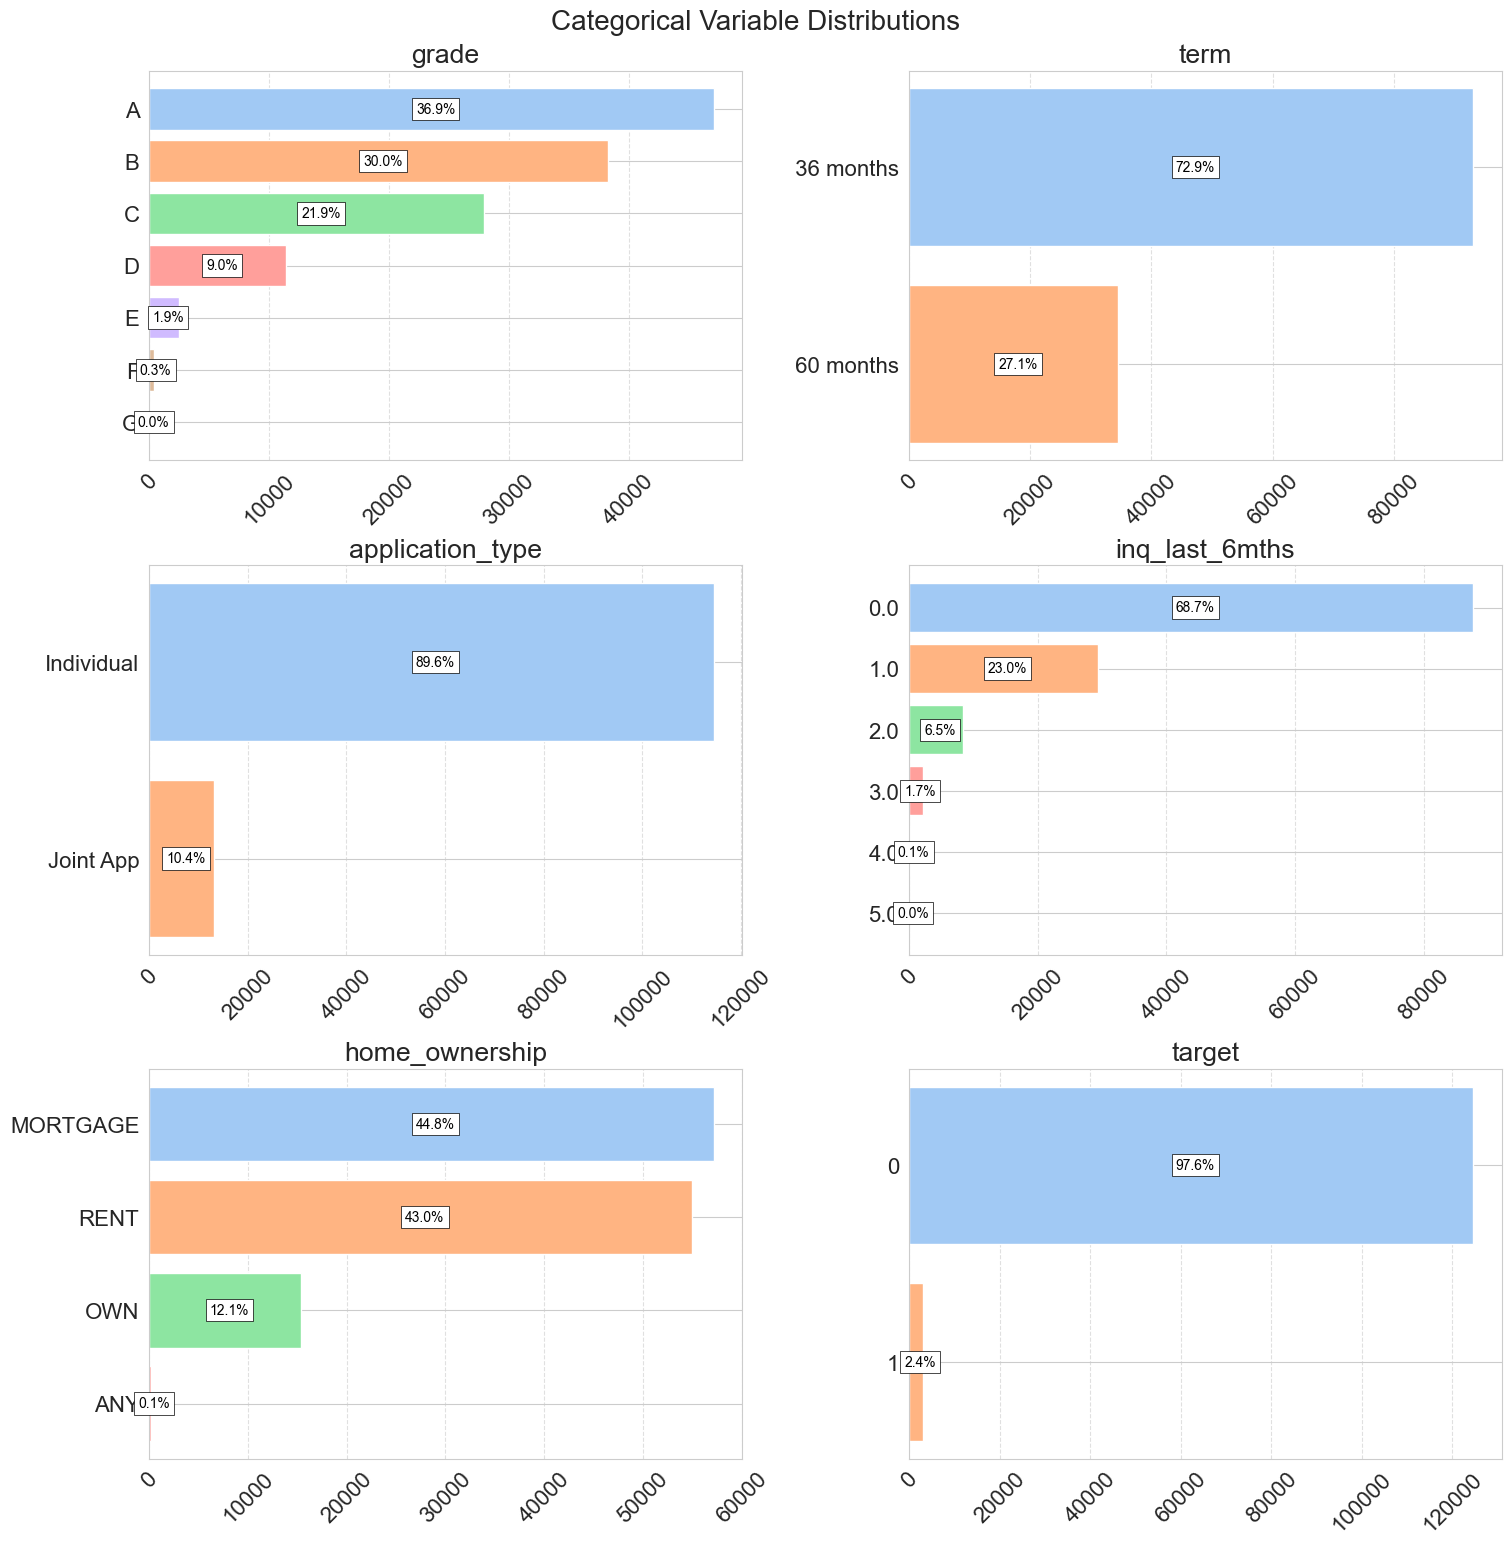

In [30]:
plt.rcParams.update({'font.size': 16})

num_plots = len(categorical_variables_vis)
num_rows = (num_plots + 1) // 2  
fig, axs = plt.subplots(num_rows, 2, sharex=False, sharey=False, constrained_layout=True, figsize=(15, 5 * num_rows))

colors = sns.color_palette("pastel")

for a, cat_col in enumerate(categorical_variables_vis):
    value_counts = df[cat_col].value_counts()
    x_pos = np.arange(0, df[cat_col].nunique())

    trace_x = a // 2
    trace_y = a % 2

    bars = axs[trace_x, trace_y].barh(x_pos, value_counts.values, tick_label=value_counts.index, color=colors)

    axs[trace_x, trace_y].set_title(cat_col)
    axs[trace_x, trace_y].invert_yaxis()  

    for tick in axs[trace_x, trace_y].get_xticklabels():
        tick.set_rotation(45)

    axs[trace_x, trace_y].grid(axis='x', linestyle='--', alpha=0.6)

    total = sum(value_counts.values)
    for bar in bars:
        percentage = f'{bar.get_width() / total * 100:.1f}%'
        bbox_props = dict(boxstyle="square,pad=0.3", fc="white", ec="black", lw=0.5)
        axs[trace_x, trace_y].annotate(percentage,
                                      xy=(bar.get_x() + bar.get_width() / 2, bar.get_y() + bar.get_height() / 2),
                                      xytext=(3, 0),  
                                      textcoords="offset points",
                                      ha='center', va='center', fontsize=10, color='black',
                                      bbox=bbox_props)


plt.suptitle('Categorical Variable Distributions', y=1.02, fontsize=20)

plt.show()


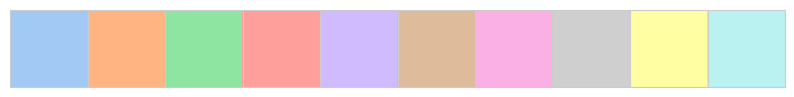

In [31]:
# Set palette for seaborn
sns.set_palette(palette="pastel")
sns.palplot(sns.color_palette())

In [32]:
# Plot the correlation matrix
df_corr = df[continuous_variables_vis]

corr = df_corr.corr()
pio.templates.default = "plotly_white"

trace = go.Heatmap(z=corr.values,
                  x=corr.index.values,
                  y=corr.columns.values,
                  colorscale=px.colors.sequential.RdBu,
                  zmin=-1,
                  zmax=1)

layout = go.Layout(
    title='Pearson Correlation of features',
    xaxis = dict(ticks='', nticks=52),
    yaxis = dict(ticks='' ),
    width = 800, height = 600,
margin=dict(
    l=240,
),)

fig = go.Figure(layout=layout)
fig.add_trace(trace)
fig.show()

In [33]:
numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns
categorical_cols = df.select_dtypes(include=['object', 'category']).columns.difference(['target'])

In [34]:
# Perform one-hot encoding on the categorical columns
df_clean = pd.get_dummies(df, columns = categorical_cols)

In [35]:
df_clean = df_clean.select_dtypes(include=['number'])

In [36]:
# Split the data into train and test sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(
    df_clean.drop('target', axis=1), df_clean['target'], test_size=0.2, random_state=SEED)

In [37]:
numerical_cols = X_train.select_dtypes(include=['int64', 'float64']).columns
categorical_cols = X_train.select_dtypes(include=['object', 'category']).columns

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean'))
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

X_train_imputed = preprocessor.fit_transform(X_train)
X_test_imputed = preprocessor.transform(X_test)

imputed_columns = numerical_cols.tolist() + categorical_cols.tolist()

X_train_imputed = pd.DataFrame(X_train_imputed, columns=imputed_columns)
X_test_imputed = pd.DataFrame(X_test_imputed, columns=imputed_columns)


In [38]:
classifiers = [
    ("Logistic Regression", LogisticRegression(max_iter=1000)),
    ("Random Forest", RandomForestClassifier()),
    ("XGBoost", XGBClassifier(use_label_encoder=False, eval_metric='logloss')),
    ("LightGBM", LGBMClassifier()),
    ("Decision Tree", DecisionTreeClassifier()),
    ("Naive Bayes", GaussianNB()),
    ("LDA", LinearDiscriminantAnalysis()),
    ("Gradient Boosting", GradientBoostingClassifier()),
    ("CatBoost", CatBoostClassifier(silent=True))
]

# Train and evaluate the models
for name, model in classifiers:
    if name == "CatBoost":
        model.fit(X_train_imputed, y_train, verbose_eval=False)
    else:
        model.fit(X_train_imputed, y_train)
    y_pred = model.predict(X_test_imputed)
    acc_te = accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_pred)
    print(f"For {name}::\nTesting Accuracy is: {acc_te}\nTesting AUC is: {auc}")
    print("--" * 40)

c:\Users\adamj\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



For Logistic Regression::
Testing Accuracy is: 0.987588583062527
Testing AUC is: 0.7549665082336527
--------------------------------------------------------------------------------
For Random Forest::
Testing Accuracy is: 0.9883324850240789
Testing AUC is: 0.7774763969663887
--------------------------------------------------------------------------------
For XGBoost::
Testing Accuracy is: 0.9924826749148428
Testing AUC is: 0.8515212339515367
--------------------------------------------------------------------------------
[LightGBM] [Info] Number of positive: 2459, number of negative: 99702
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006229 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 12723
[LightGBM] [Info] Number of data points in the train set: 102161, number of used features: 107
[LightGBM] [Info] [binary:BoostFromScore]: pavg

## Deep dive into LGBM

In [39]:
def forward_feature_selection_logloss(model, X, y, test_size=0.2, threshold=0.01, random_state=SEED, max_features_per_iteration=200):
    selected_features = []
    logloss_scores = []
    best_logloss = np.inf

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)

    while True:
        improvement = False
        best_feature = None

        features_to_evaluate = [f for f in X.columns if f not in selected_features]
        if len(features_to_evaluate) > max_features_per_iteration:
            features_to_evaluate = np.random.choice(features_to_evaluate, max_features_per_iteration, replace=False)

        for feature in features_to_evaluate:
            candidate_features = selected_features + [feature]
            model.fit(X_train[candidate_features], y_train)
            y_pred_proba = model.predict_proba(X_test[candidate_features])
            temp_logloss = log_loss(y_test, y_pred_proba)

            if best_logloss - temp_logloss > threshold:
                print(f"Improvement with {feature}: {best_logloss} -> {temp_logloss}")
                best_logloss = temp_logloss
                best_feature = feature
                improvement = True
            else:
                print(f"No sufficient improvement with {feature}: {temp_logloss}")

        if improvement and best_feature is not None:
            selected_features.append(best_feature)
            logloss_scores.append(best_logloss)
        else:
            print("-" * 50)
            print("No improvement beyond the threshold or no features left to evaluate.")
            print("Final features:", selected_features)
            break

        print("-" * 50)
        print("Current features: ", selected_features)
        print("Log Loss: ", best_logloss)
        print("-" * 50)

    return {"selected_features": selected_features, "logloss_scores": logloss_scores}


In [40]:
X = df_clean[df_clean.columns.difference(["target"])]
y = df_clean["target"]

In [41]:
start_params = {
    "objective": "binary",
    "metric": "binary_logloss",
    "tree_method": "hist",
    "verbosity": -1,
}

model = lgb.LGBMClassifier(**start_params, random_state=SEED)

# Fit the model
model.fit(X, y)


LGBMClassifier(metric='binary_logloss', objective='binary',
               random_state=420692115, tree_method='hist', verbosity=-1)

In [42]:
features_forward_selection = forward_feature_selection_logloss(
    lgb.LGBMClassifier(**start_params), X, y, threshold=0.0001
)
features_forward_selection

Improvement with addr_state_FL: inf -> 0.11374602623866771
No sufficient improvement with hardship_start_date_Oct-2018: 0.11380476722247257
Improvement with total_pymnt_inv: 0.11374602623866771 -> 0.11179964220333313
No sufficient improvement with num_accts_ever_120_pd: 0.11380841414325506
No sufficient improvement with addr_state_NM: 0.11380491572926704
Improvement with last_pymnt_d_Jan-2019: 0.11179964220333313 -> 0.10623293279241323
No sufficient improvement with sub_grade_G3: 0.11380476722247257
No sufficient improvement with addr_state_MO: 0.11381294076757684
No sufficient improvement with last_credit_pull_d_Oct-2018: 0.11360006384217633
No sufficient improvement with last_pymnt_d_Sep-2018: 0.11201187045924783
No sufficient improvement with total_bal_ex_mort: 0.1146491406511415
No sufficient improvement with num_tl_120dpd_2m: 0.1135566177232985
No sufficient improvement with hardship_start_date_Feb-2019: 0.11380476722247257
No sufficient improvement with total_acc: 0.1140573472183

{'selected_features': ['last_fico_range_high',
  'last_pymnt_d_Jan-2019',
  'last_pymnt_d_Mar-2019',
  'last_pymnt_amnt',
  'next_pymnt_d_Apr-2019',
  'last_pymnt_d_Feb-2019',
  'total_pymnt',
  'funded_amnt_inv',
  'total_rec_late_fee',
  'hardship_amount',
  'total_rec_int',
  'num_actv_rev_tl',
  'mo_sin_old_rev_tl_op'],
 'logloss_scores': [0.061419802513590804,
  0.05433241915050664,
  0.036482200475403195,
  0.029234113653850514,
  0.026610282769207908,
  0.022932109526344488,
  0.021403269961032843,
  0.019788232934181138,
  0.018785752829107036,
  0.01731254072007968,
  0.016860630752073908,
  0.01674388632297766,
  0.016456069840311054]}

In [69]:
# from sklearn.feature_selection import RFECV

# selector = RFECV(
#     lgb.LGBMClassifier(**start_params), step=1, cv=5, scoring="neg_log_loss"
# )
# selector = selector.fit(X, y)

# # Get the list of selected feature names
# selected_features_rfecv = X.columns[selector.support_]

# selected_features_rfecv

In [148]:
selected_features_rfecv = ['acc_open_past_24mths', 'addr_state_MN', 'all_util', 'annual_inc',
       'annual_inc_joint', 'avg_cur_bal', 'bc_open_to_buy', 'bc_util', 'dti',
       'il_util', 'max_bal_bc', 'mo_sin_old_il_acct',
       'mo_sin_rcnt_rev_tl_op', 'mths_since_last_major_derog', 'out_prncp',
       'tot_coll_amt', 'total_pymnt']

In [149]:
len(selected_features_rfecv)
final_features = selected_features_rfecv

In [150]:
X = df_clean[final_features]
y = df_clean["target"]

In [151]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=SEED
)

X_train

,acc_open_past_24mths,addr_state_MN,all_util,annual_inc,annual_inc_joint,avg_cur_bal,bc_open_to_buy,bc_util,dti,il_util,max_bal_bc,mo_sin_old_il_acct,mo_sin_rcnt_rev_tl_op,mths_since_last_major_derog,out_prncp,tot_coll_amt,total_pymnt
71668,3.0,0,88.0,120000.0,NaN,84500.0,11810.0,87.8,26.73,NaN,32937.0,208.0,8.0,NaN,36057.67,0.0,4930.110000
112135,10.0,0,96.0,25000.0,NaN,1896.0,433.0,13.4,5.73,105.0,67.0,90.0,3.0,21.0,9379.15,0.0,1622.930000
22265,8.0,0,54.0,105000.0,NaN,108277.0,20861.0,19.8,6.00,98.0,4090.0,89.0,30.0,NaN,2125.90,0.0,1476.950000
47814,15.0,0,23.0,78600.0,NaN,982.0,36245.0,22.9,28.32,30.0,3402.0,171.0,2.0,28.0,16584.74,0.0,4618.200000
11161,7.0,0,53.0,85000.0,NaN,31628.0,23634.0,31.3,19.59,75.0,8282.0,211.0,5.0,60.0,0.00,0.0,31960.119198
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17151,5.0,0,84.0,25800.0,55800.0,2905.0,784.0,95.8,35.53,88.0,6725.0,119.0,21.0,NaN,10417.58,0.0,7956.180000
95955,2.0,0,76.0,34000.0,NaN,4992.0,424.0,90.6,30.92,78.0,2823.0,47.0,12.0,NaN,0.00,0.0,4781.655980
102407,0.0,0,86.0,58200.0,NaN,7656.0,1822.0,72.0,18.47,NaN,4678.0,118.0,46.0,NaN,23012.55,0.0,8252.730000
9317,2.0,0,60.0,106700.0,NaN,40210.0,2692.0,80.6,12.51,58.0,5278.0,88.0,2.0,NaN,7967.10,0.0,4836.310000


In [152]:
def random_search(
    X,
    y,
    params,
    model,
    n_iter=10,
    n_splits=5,
    scoring="neg_log_loss",
    seed=SEED,
):
    random_search = RandomizedSearchCV(
        model,
        param_distributions=params,
        n_iter=n_iter,
        scoring=scoring,
        n_jobs=-1,
        cv=KFold(n_splits=n_splits, shuffle=True, random_state=seed),
        random_state=seed,
        verbose=4,
    )

    try:
        random_search.fit(X, y, verbose=False)
    except:
        random_search.fit(X, y)

    results = {
        "best_params": random_search.best_params_,
        "best_score": -random_search.best_score_,
        "cv_results": random_search.cv_results_,
    }
    return results

In [153]:
model = LGBMClassifier(random_state=SEED, verbose=-1)

params = {
    "learning_rate": np.logspace(-3, 0, 20),
    "subsample": np.linspace(0.5, 1.0, 6),
    "colsample_bytree": np.linspace(0.5, 1.0, 6),
    "reg_alpha": np.logspace(-2, 1, 10),
    "reg_lambda": np.logspace(-2, 1, 10),
}

results = random_search(X_train, y_train, params, model, n_iter=100, n_splits=5, scoring="neg_log_loss", seed=SEED)

best_params = results["best_params"]
best_score = results["best_score"]

Fitting 5 folds for each of 100 candidates, totalling 500 fits
Fitting 5 folds for each of 100 candidates, totalling 500 fits


In [154]:
best_params

{'subsample': 0.7,
 'reg_lambda': 1.0,
 'reg_alpha': 0.046415888336127774,
 'learning_rate': 0.05455594781168517,
 'colsample_bytree': 0.8}

In [155]:
lgbm_best_params = best_params

In [156]:
def gini(y_true, y_pred_proba):
    auc = roc_auc_score(y_true, y_pred_proba)
    return 2 * auc - 1

def cross_validate_model_classification(X, y, input_model, n_splits=5):
    # Define custom scoring functions
    scoring = {
        'AUC': 'roc_auc',
        'Accuracy': 'accuracy',
        'Balanced Accuracy': make_scorer(balanced_accuracy_score),
        'Precision': make_scorer(precision_score),
        'Recall': make_scorer(recall_score),
        'Gini': make_scorer(gini, needs_proba=True),
        'Kappa': make_scorer(cohen_kappa_score)
    }

    scores = cross_validate(input_model, X, y, cv=n_splits, scoring=scoring, return_train_score=False)
    
    print("Cross-Validated Model Evaluation Metrics:")
    for metric in scoring.keys():
        print(f"{metric}: {scores[f'test_{metric}'].mean():.2f} (+/- {scores[f'test_{metric}'].std() * 2:.2f})")

In [157]:
cv_lgbm_model = LGBMClassifier(**best_params, random_state=SEED, verbose=-1)
cross_validate_model_classification(X_train, y_train, cv_lgbm_model)

Cross-Validated Model Evaluation Metrics:
AUC: 0.81 (+/- 0.02)
Accuracy: 0.98 (+/- 0.00)
Balanced Accuracy: 0.67 (+/- 0.02)
Precision: 0.82 (+/- 0.03)
Recall: 0.35 (+/- 0.04)
Gini: 0.63 (+/- 0.04)
Kappa: 0.48 (+/- 0.04)


In [158]:
def gini(y_true, y_pred_proba):
    auc = roc_auc_score(y_true, y_pred_proba)
    return 2 * auc - 1

lgbm_model = LGBMClassifier(**best_params, random_state=SEED, verbose=-1)
lgbm_model.fit(X_train, y_train)

y_pred_proba = lgbm_model.predict_proba(X_test)[:, 1]

y_pred = lgbm_model.predict(X_test)

auc = roc_auc_score(y_test, y_pred_proba)
accuracy = accuracy_score(y_test, y_pred)
balanced_accuracy = balanced_accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
gini_score = gini(y_test, y_pred_proba)
kappa = cohen_kappa_score(y_test, y_pred)

print(f"Model Evaluation Metrics:")
print(f"Area Under Curve (AUC): {auc:.2f}")
print(f"Accuracy: {accuracy:.2f}")
print(f"Balanced Accuracy: {balanced_accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"Gini Coefficient: {gini_score:.2f}")
print(f"Cohen's Kappa: {kappa:.2f}")

Model Evaluation Metrics:
Area Under Curve (AUC): 0.80
Accuracy: 0.98
Balanced Accuracy: 0.67
Precision: 0.85
Recall: 0.35
Gini Coefficient: 0.61
Cohen's Kappa: 0.48


In [159]:
# Evaluate the model

from sklearn.metrics import average_precision_score
y_pr_train_proba = lgbm_model.predict_proba(X_train)[:, 1]  
y_pr_train_binary = lgbm_model.predict(X_train)

acc_train = accuracy_score(y_train, y_pr_train_binary)
acc_balanced_train = balanced_accuracy_score(y_train, y_pr_train_binary)
class_re = classification_report(y_train, y_pr_train_binary)
con_mat = confusion_matrix(y_train, y_pr_train_binary)
auc_train = roc_auc_score(y_train, y_pr_train_proba)
auc_pr_train = average_precision_score(y_train, y_pr_train_proba)

print("Confusion Matrix:\n", con_mat)
print("\n")
print("Accuracy of the model:", acc_train * 100)
print("\n")
print("Balanced accuracy of the model:", acc_balanced_train * 100)
print("\n")
print("Classification report:\n", class_re)
print("AUC of the model:", auc_train)
print("AUC PR of the model:", auc_pr_train)

Confusion Matrix:
 [[99568   134]
 [ 1515   944]]


Accuracy of the model: 98.38588110922954


Balanced accuracy of the model: 69.12759437519905


Classification report:
               precision    recall  f1-score   support

           0       0.99      1.00      0.99     99702
           1       0.88      0.38      0.53      2459

    accuracy                           0.98    102161
   macro avg       0.93      0.69      0.76    102161
weighted avg       0.98      0.98      0.98    102161

AUC of the model: 0.9216523434221943
AUC PR of the model: 0.5914935559478889


In [160]:
# Test the model
y_pr_test_proba = lgbm_model.predict_proba(X_test)[:, 1]
y_pr_test_binary = lgbm_model.predict(X_test)

acc_test = accuracy_score(y_test, y_pr_test_binary)
acc_balanced_test = balanced_accuracy_score(y_test, y_pr_test_binary)
class_re1 = classification_report(y_test, y_pr_test_binary)
con_mat1 = confusion_matrix(y_test, y_pr_test_binary)
auc_test = roc_auc_score(y_test, y_pr_test_proba)
auc_pr_test = average_precision_score(y_test, y_pr_test_proba)

print("Confusion Matrix:\n", con_mat1)
print("\n")
print("Accuracy of the model:", acc_test * 100)
print("\n")
print("Balanced accuracy of the model:", acc_balanced_test * 100)
print("\n")
print("Classification report:\n", class_re1)
print("AUC of the model:", auc_test)
print("AUC PR of the model:", auc_pr_test)

Confusion Matrix:
 [[24885    39]
 [  404   213]]


Accuracy of the model: 98.26553384753926


Balanced accuracy of the model: 67.18270218937205


Classification report:
               precision    recall  f1-score   support

           0       0.98      1.00      0.99     24924
           1       0.85      0.35      0.49       617

    accuracy                           0.98     25541
   macro avg       0.91      0.67      0.74     25541
weighted avg       0.98      0.98      0.98     25541

AUC of the model: 0.8045936470208169
AUC PR of the model: 0.4493577981826409


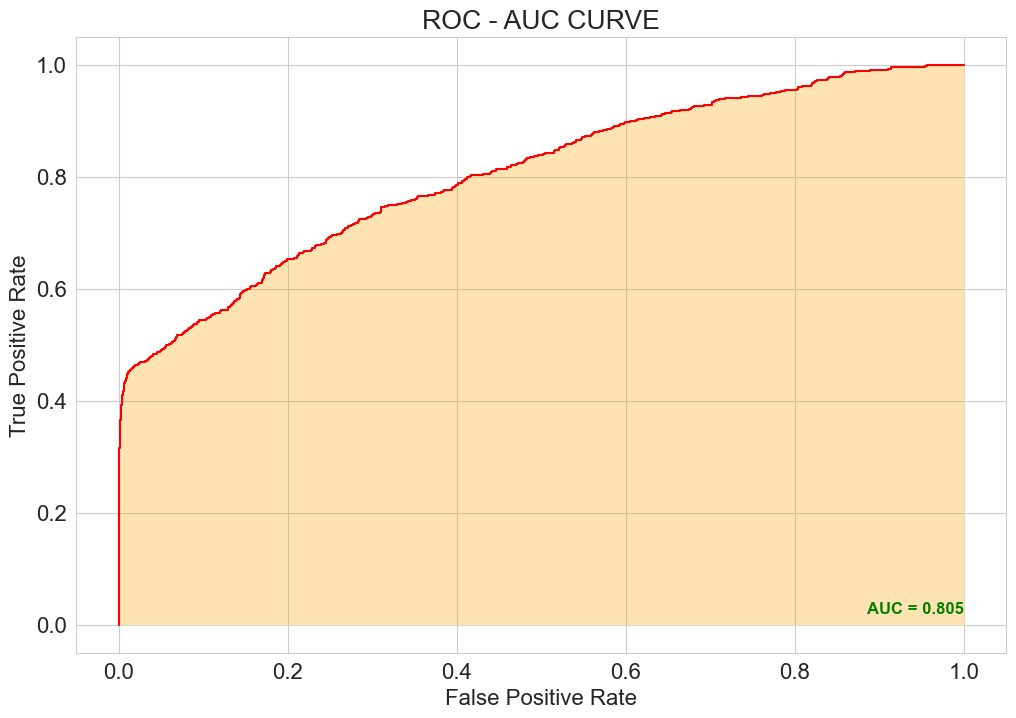

In [161]:
# Ploting the Roc - Auc Curve on Testing data
y_prob = lgbm_model.predict_proba(X_test)
y_pr   = y_prob[:,1]
auc_score = roc_auc_score(y_test, y_pr)
fpr,tpr,threshold = roc_curve(y_test,y_pr)
plt.figure(figsize=(12, 8))
plt.plot(fpr,tpr, "r")
plt.text(1, 0.02, 'AUC = %0.3f' % auc_score, ha='right', fontsize=12,weight='bold', color='green')
plt.fill_between(fpr, tpr, facecolor='orange', alpha=0.3)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC - AUC CURVE")
plt.show()

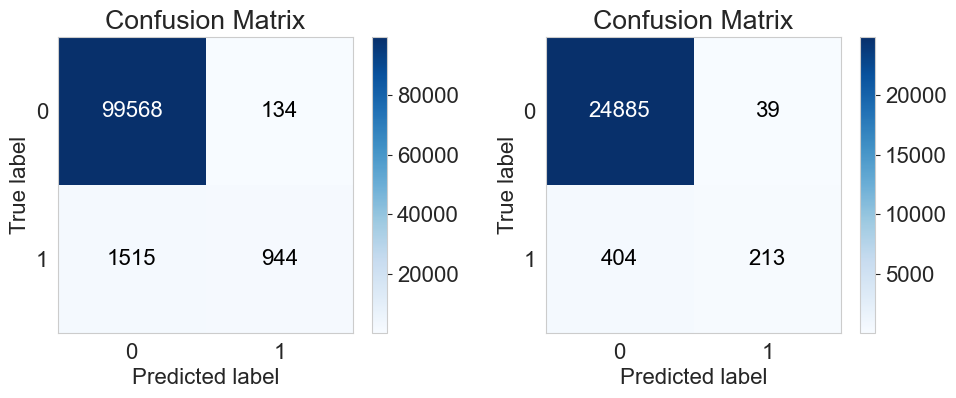

In [162]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

axes[0].set_title('Confusion Matrix - Train')
skplt.metrics.plot_confusion_matrix(y_train, y_pr_train_binary, ax=axes[0])
axes[1].set_title('Confusion Matrix - Test')
skplt.metrics.plot_confusion_matrix(y_test, y_pr_test_binary, ax=axes[1])

plt.tight_layout()
plt.show()

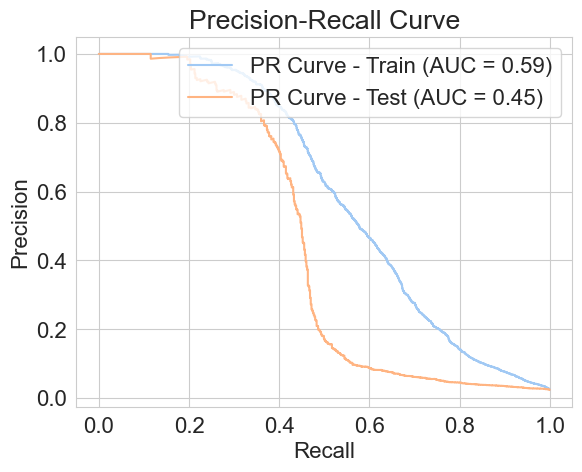

In [163]:
# Precision-Recall Curve

pr_auc_train = average_precision_score(y_train, y_pr_train_proba)
pr_auc_test = average_precision_score(y_test, y_pr_test_proba)

precision_train, recall_train, _ = precision_recall_curve(y_train, y_pr_train_proba)
precision_test, recall_test, _ = precision_recall_curve(y_test, y_pr_test_proba)

plt.plot(recall_train, precision_train, label=f'PR Curve - Train (AUC = {pr_auc_train:.2f})')
plt.plot(recall_test, precision_test, label=f'PR Curve - Test (AUC = {pr_auc_test:.2f})')
plt.title('Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.show()

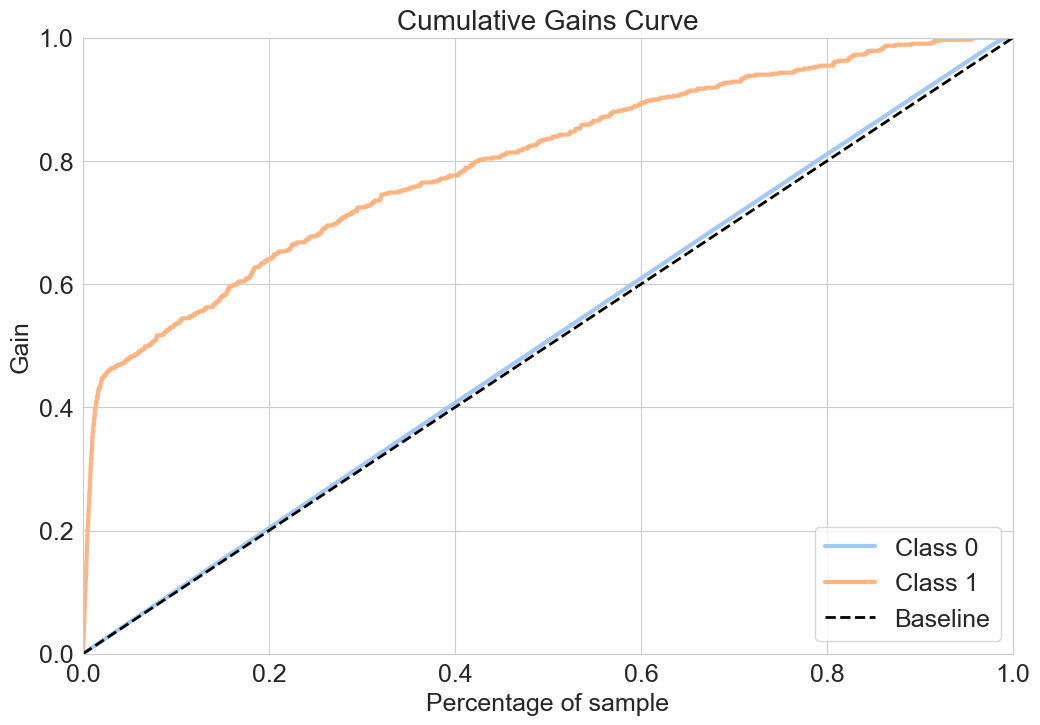

In [164]:
# Plot the Cumulative Gains Curve
skplt.metrics.plot_cumulative_gain(y_test, y_prob, figsize=(12, 8), title_fontsize=20, text_fontsize=18)
plt.show()

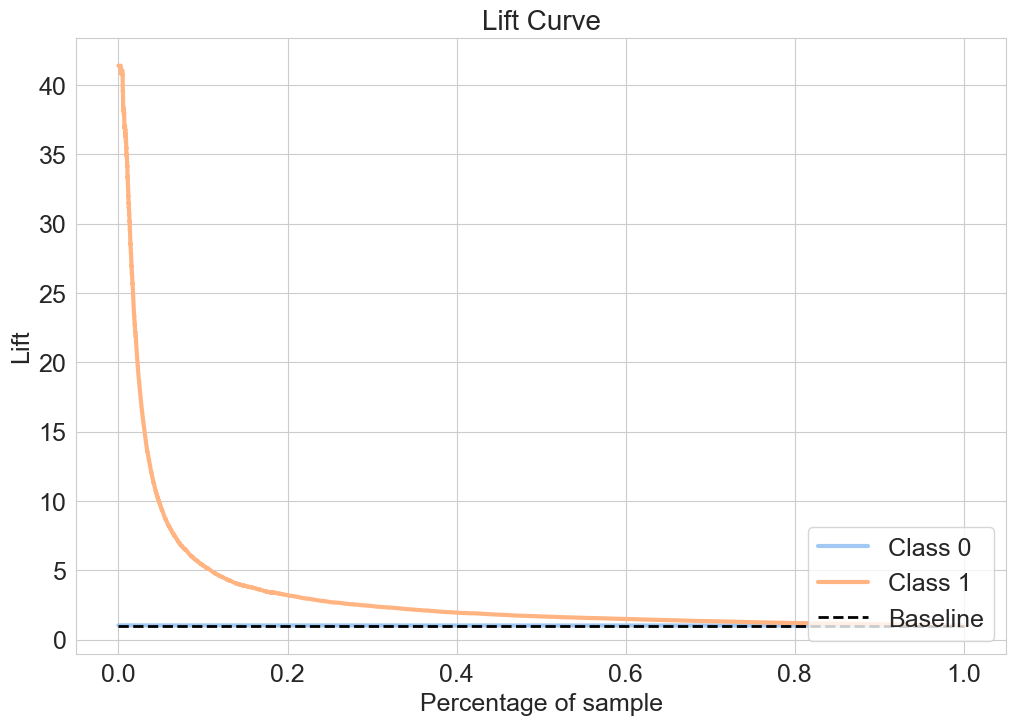

In [165]:
# Plot the Lift Curve
skplt.metrics.plot_lift_curve(y_test, y_prob, figsize=(12, 8), title_fontsize=20, text_fontsize=18)
plt.show()

c:\Users\adamj\AppData\Local\Programs\Python\Python311\Lib\site-packages\shap\explainers\_tree.py:426: UserWarning:

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray



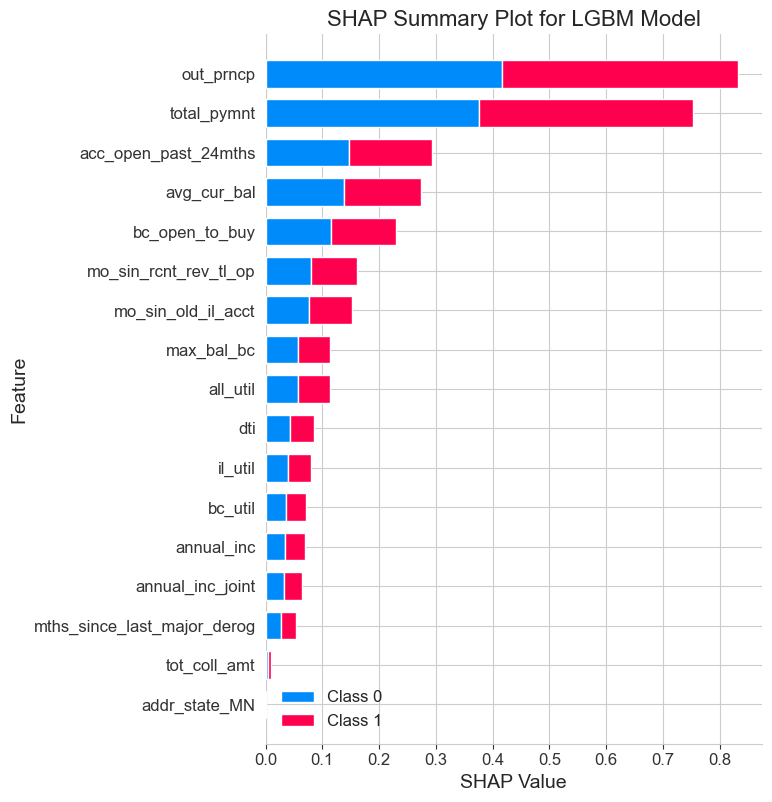

In [166]:
explainer = shap.TreeExplainer(lgbm_model)
shap_values = explainer.shap_values(X_test)

shap.summary_plot(shap_values, X_test, plot_type="bar", show=False)

plt.title("SHAP Summary Plot for LGBM Model", fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel("SHAP Value", fontsize=14)
plt.ylabel("Feature", fontsize=14)
plt.tight_layout()

plt.show()

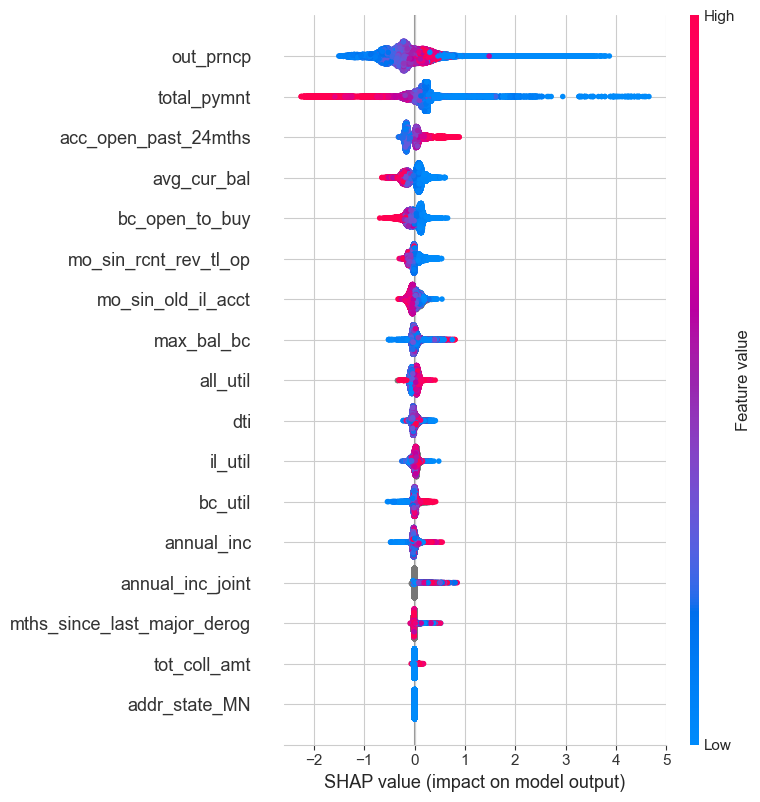

In [167]:
shap.summary_plot(shap_values[1], X_test, feature_names = X_test.columns)

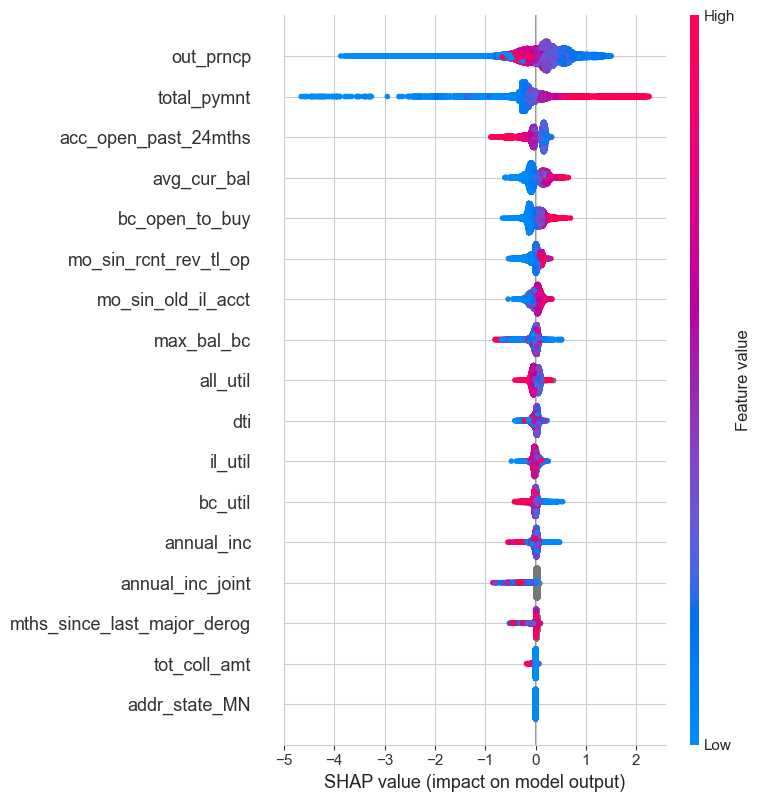

In [168]:
shap.summary_plot(shap_values[0], X_test, feature_names = X_test.columns)

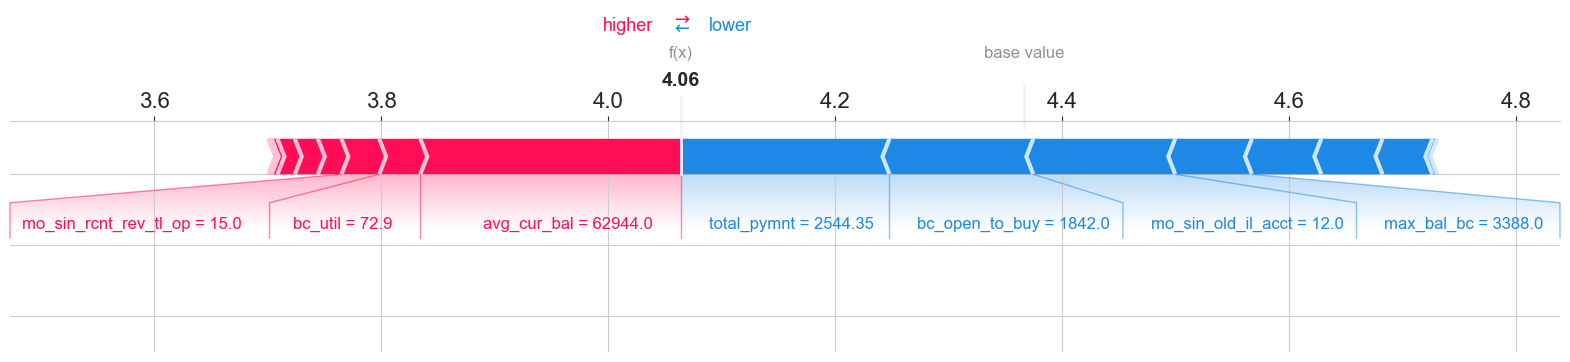

In [169]:
i=24
shap.force_plot(explainer.expected_value[0], shap_values[0][i], X_test.values[i], feature_names = X_test.columns, matplotlib=True)

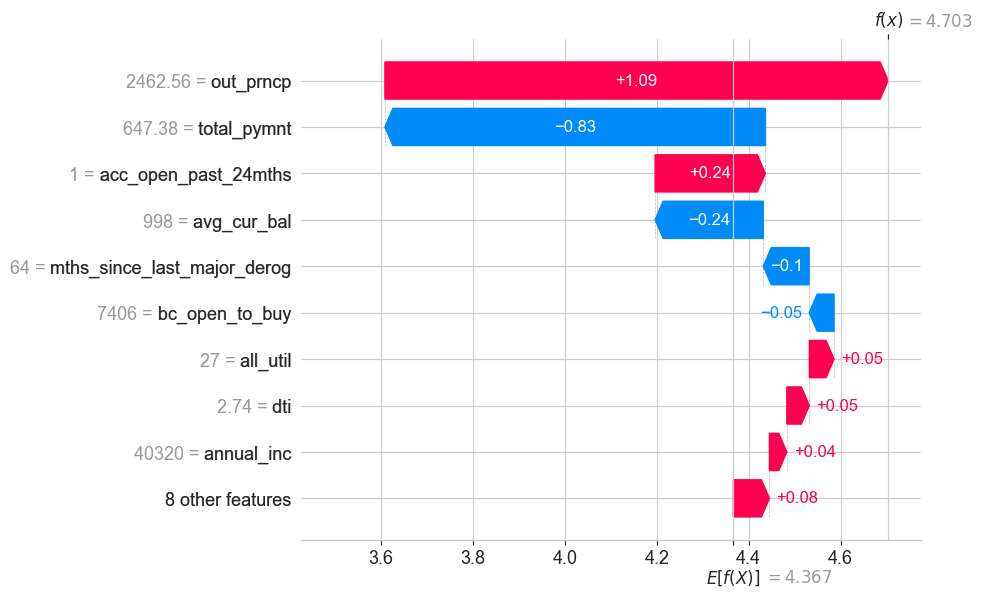

In [170]:
row = 12
shap.waterfall_plot(shap.Explanation(values=shap_values[0][row], 
                                              base_values=explainer.expected_value[0], data=X_test.iloc[row],  
                                         feature_names=X_test.columns.tolist()))